# Clustering

Clustering techniques are unsupervised learning algorithms that try to group unlabelled data into "clusters", using the (typically spatial) structure of the data itself. It has many [applications](https://en.wikipedia.org/wiki/Cluster_analysis#Applications).

The easiest way to demonstrate how clustering works is to simply generate some data and show them in action. We'll start off by importing the libraries we'll be using today.

In [1]:
import math, matplotlib.pyplot as plt, operator, torch
from functools import partial

In [2]:
#check which interprter

import sys
print(sys.executable)

/home/jesse/lab/fastai/course22p2/fastai2022/.venv/bin/python


In [3]:
torch.manual_seed(42)
torch.set_printoptions(precision=3, linewidth=140, sci_mode=False)

## things to remember

partials: creates a copy of a func with a set value of an input. 


create animations:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
    - createa func which does one round and then clear plot

## Create data

In [4]:
n_clusters=6
n_samples =250

To generate our data, we're going to pick 6 random points, which we'll call centroids, and for each point we're going to generate 250 random points about it.

In [5]:
centroids = torch.rand(n_clusters, 2)*70-35
centroids

tensor([[ 26.759,  29.050],
        [ -8.200,  32.151],
        [ -7.669,   7.063],
        [-17.040,  20.555],
        [ 30.854, -25.677],
        [ 30.422,   6.551]])

In [6]:
from torch.distributions.multivariate_normal import MultivariateNormal
from torch import tensor

In [7]:
#create a multivariate dist with two variables: the coords of the centroid. 
# intiatlise a covariance matrix. in this case a diagonal matrix: [5,0],[0,5] meaning that each variable has a variance of 5, and there is no covariation. 
# then sample n_samples from the dist. 
#finally sample((n_samples,)) is because pytorch expects a tuple when sampling: (n samples, shape of return = shape of dist)

def sample(m): return MultivariateNormal(m, torch.diag(tensor([5.,5.]))).sample((n_samples,))

In [8]:
centroids[1]

tensor([-8.200, 32.151])

In [9]:
torch.diag(tensor([5.,5.])),tensor([5.,5.])

(tensor([[5., 0.],
         [0., 5.]]),
 tensor([5., 5.]))

In [10]:
MultivariateNormal(centroids[1], torch.diag(tensor([5.,5.]))).sample((3,))

tensor([[-3.262, 30.725],
        [-7.167, 32.749],
        [-7.003, 33.961]])

In [11]:
(3,)

(3,)

In [12]:
slices = [sample(c) for c in centroids]
data = torch.cat(slices)
data.shape, data[:2]

(torch.Size([1500, 2]),
 tensor([[27.555, 27.515],
         [25.656, 29.590]]))

Below we can see each centroid marked w/ X, and the coloring associated to each respective cluster.

In [13]:
def plot_data(centroids, data, n_samples, ax=None):
    if ax is None: _,ax = plt.subplots()
    for i, centroid in enumerate(centroids):
        samples = data[i*n_samples:(i+1)*n_samples]
        ax.scatter(samples[:,0], samples[:,1], s=1)
        ax.plot(*centroid, markersize=10, marker="x", color='k', mew=5)
        ax.plot(*centroid, markersize=5, marker="x", color='m', mew=2)

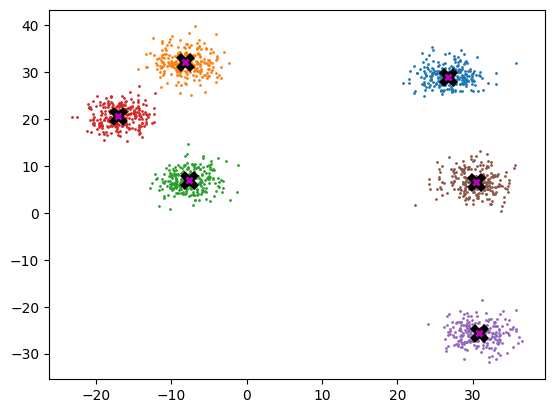

In [14]:
plot_data(centroids, data, n_samples)

## Mean shift

Most people that have come across clustering algorithms have learnt about **k-means**. Mean shift clustering is a newer and less well-known approach, but it has some important advantages:
* It doesn't require selecting the number of clusters in advance, but instead just requires a **bandwidth** to be specified, which can be easily chosen automatically
* It can handle clusters of any shape, whereas k-means (without using special extensions) requires that clusters be roughly ball shaped.

The algorithm is as follows:
* For each data point x in the sample X, find the distance between that point x and every other point in X
* Create weights for each point in X by using the **Gaussian kernel** of that point's distance to x
    * This weighting approach penalizes points further away from x
    * The rate at which the weights fall to zero is determined by the **bandwidth**, which is the standard deviation of the Gaussian
* Update x as the weighted average of all other points in X, weighted based on the previous step

This will iteratively push points that are close together even closer until they are next to each other.

In [15]:
midp = data.mean(0)
midp

tensor([ 9.226, 11.636])

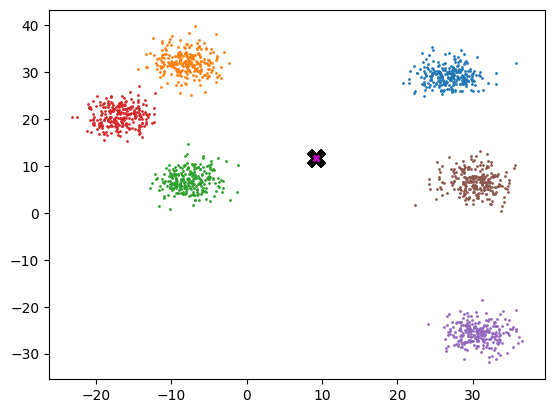

In [16]:
plot_data([midp]*6, data, n_samples)

So here's the definition of the gaussian kernel, which you may remember from high school...
 This person at the science march certainly remembered!

<img src="http://i.imgur.com/nijQLHw.jpg" width=400>

In [17]:
def gaussian(d, bw): return torch.exp(-0.5*((d/bw))**2) / (bw*math.sqrt(2*math.pi))

In [18]:
def plot_func(f):
    x = torch.linspace(0,10,100)
    plt.plot(x, f(x))

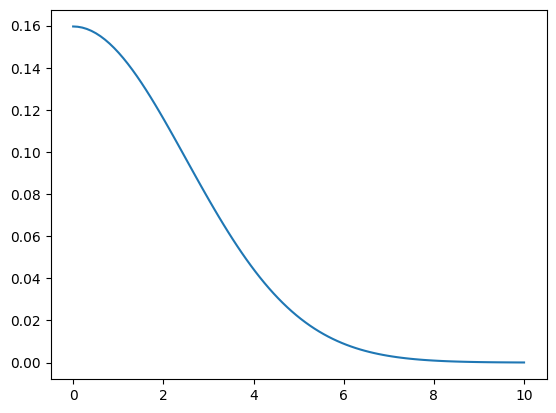

In [19]:
plot_func(partial(gaussian, bw=2.5))

In [20]:
# poartial 
partial?

Init signature: partial(self, /, *args, **kwargs)
Docstring:     
partial(func, *args, **keywords) - new function with partial application
of the given arguments and keywords.
File:           /usr/lib/python3.10/functools.py
Type:           type
Subclasses:     

In our implementation, we choose the bandwidth to be 2.5. 

One easy way to choose bandwidth is to find which bandwidth covers one third of the data.

In [21]:
def tri(d, i): return (-d+i).clamp_min(0)/i

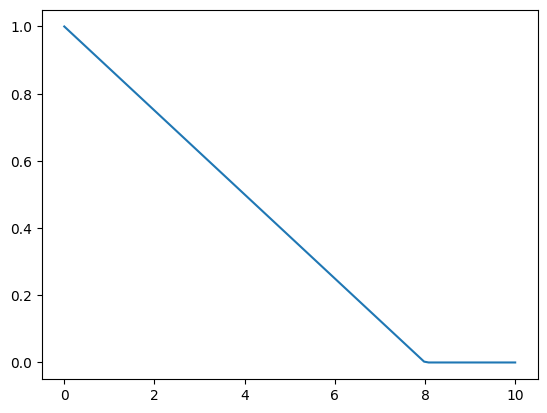

In [22]:
plot_func(partial(tri, i=8))

In [23]:
X = data.clone()
x = data[0]

In [24]:
x

tensor([27.555, 27.515])

In [25]:
x.shape,X.shape,x[None].shape

(torch.Size([2]), torch.Size([1500, 2]), torch.Size([1, 2]))

In [26]:
(x[None]-X)[:8]

tensor([[ 0.000,  0.000],
        [ 1.899, -2.075],
        [ 3.280, -1.740],
        [ 5.977, -1.051],
        [ 1.488, -0.650],
        [-1.001, -0.145],
        [ 2.119, -1.394],
        [ 2.648, -2.275]])

In [27]:
(x-X)[:8]

tensor([[ 0.000,  0.000],
        [ 1.899, -2.075],
        [ 3.280, -1.740],
        [ 5.977, -1.051],
        [ 1.488, -0.650],
        [-1.001, -0.145],
        [ 2.119, -1.394],
        [ 2.648, -2.275]])

In [29]:
# rewrite using torch.einsum
dist = ((x-X)**2).sum(1).sqrt()
dist[:8]

tensor([0.000, 2.813, 3.713, 6.068, 1.624, 1.011, 2.537, 3.492])

In [30]:
dist.min()

tensor(0.)

In [31]:
x.shape, X.shape

(torch.Size([2]), torch.Size([1500, 2]))

In [32]:
gaussian(torch.tensor([0]), 2.5)

tensor([0.160])

In [33]:
weight = gaussian(dist, 2.5)
weight

tensor([    0.160,     0.085,     0.053,  ...,     0.000,     0.000,     0.000])

In [34]:
weight.shape,X.shape

(torch.Size([1500]), torch.Size([1500, 2]))

In [35]:
weight[:,None].shape

torch.Size([1500, 1])

In [36]:
weight[:,None]*X

tensor([[    4.397,     4.391],
        [    2.174,     2.507],
        [    1.286,     1.550],
        ...,
        [    0.000,     0.000],
        [    0.000,     0.000],
        [    0.000,     0.000]])

In [37]:
def one_update(X):
    for i, x in enumerate(X):
        dist = torch.sqrt(((x-X)**2).sum(1))
#         weight = gaussian(dist, 2.5)
        weight = tri(dist, 8)
        X[i] = (weight[:,None]*X).sum(0)/weight.sum()

In [38]:
def meanshift(data):
    X = data.clone()
    for it in range(5): one_update(X)
    return X

In [39]:
%time X=meanshift(data)

CPU times: user 381 ms, sys: 0 ns, total: 381 ms
Wall time: 381 ms


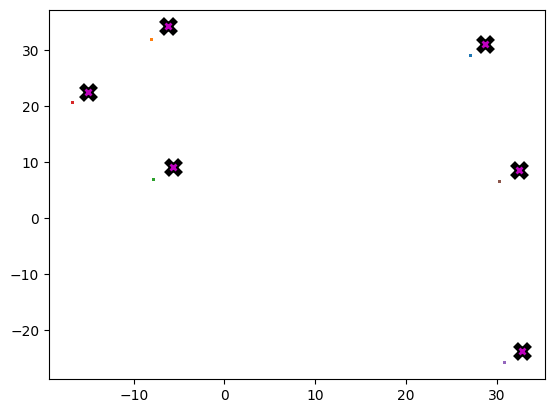

In [40]:
plot_data(centroids+2, X, n_samples)

## Animation

In [41]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [42]:
def do_one(d):
    if d: one_update(X)
    ax.clear()
    plot_data(centroids+2, X, n_samples, ax=ax)

In [43]:
# create your own animation
X = data.clone()
fig,ax = plt.subplots()
ani = FuncAnimation(fig, do_one, frames=5, interval=500, repeat=False)
plt.close()
HTML(ani.to_jshtml())

## GPU batched algorithm

To truly accelerate the algorithm, we need to be performing updates on a batch of points per iteration, instead of just one as we were doing.

In [66]:
bs=5
X = data.clone()
x = X[:bs]
x.shape,X.shape

(torch.Size([5, 2]), torch.Size([1500, 2]))

In [45]:
def dist_b(a,b): return (((a[None]-b[:,None])**2).sum(2)).sqrt()

In [46]:
dist_b(X, x)

tensor([[ 0.000,  2.813,  3.713,  ..., 17.468, 21.972, 19.654],
        [ 2.813,  0.000,  1.421,  ..., 20.034, 24.335, 22.111],
        [ 3.713,  1.421,  0.000,  ..., 20.239, 24.322, 22.194],
        [ 6.068,  4.204,  2.783,  ..., 20.885, 24.503, 22.583],
        [ 1.624,  1.483,  2.097,  ..., 18.554, 22.858, 20.629]])

In [47]:
dist_b(X, x).shape

torch.Size([5, 1500])

In [48]:
X[None,:].shape, x[:,None].shape, (X[None,:]-x[:,None]).shape

(torch.Size([1, 1500, 2]), torch.Size([5, 1, 2]), torch.Size([5, 1500, 2]))

In [49]:
weight = gaussian(dist_b(X, x), 2)
weight

tensor([[    0.199,     0.074,     0.036,  ...,     0.000,     0.000,     0.000],
        [    0.074,     0.199,     0.155,  ...,     0.000,     0.000,     0.000],
        [    0.036,     0.155,     0.199,  ...,     0.000,     0.000,     0.000],
        [    0.002,     0.022,     0.076,  ...,     0.000,     0.000,     0.000],
        [    0.143,     0.152,     0.115,  ...,     0.000,     0.000,     0.000]])

In [50]:
weight.shape,X.shape

(torch.Size([5, 1500]), torch.Size([1500, 2]))

In [51]:
weight[...,None].shape, X[None].shape

(torch.Size([5, 1500, 1]), torch.Size([1, 1500, 2]))

In [52]:
num = (weight[...,None]*X[None]).sum(1)
num.shape

torch.Size([5, 2])

In [53]:
num

tensor([[548.960, 569.866],
        [555.972, 620.585],
        [405.019, 464.326],
        [117.351, 141.431],
        [569.842, 616.567]])

In [54]:
torch.einsum('ij,jk->ik', weight, X)

tensor([[548.960, 569.866],
        [555.972, 620.585],
        [405.019, 464.326],
        [117.351, 141.431],
        [569.842, 616.567]])

In [55]:
weight@X

tensor([[548.960, 569.866],
        [555.972, 620.585],
        [405.019, 464.326],
        [117.351, 141.431],
        [569.842, 616.567]])

In [56]:
div = weight.sum(1, keepdim=True)
div.shape,div

(torch.Size([5, 1]),
 tensor([[20.071],
         [21.179],
         [15.927],
         [ 4.914],
         [21.511]]))

In [57]:
num/div

tensor([[27.350, 28.392],
        [26.251, 29.302],
        [25.429, 29.153],
        [23.879, 28.779],
        [26.490, 28.662]])

In [64]:
def meanshift(data, bs=500):
    n = len(data)
    X = data.clone()
    for it in range(5):
        for i in range(0, n, bs):
            s = slice(i, min(i+bs,n))
            weight = gaussian(dist_b(X, X[s]), 2.5)
#             weight = tri(dist_b(X, X[s]), 8)
            div = weight.sum(1, keepdim=True)
            X[s] = weight@X/div
    return X

Although each iteration still has to launch a new cuda kernel, there are now fewer iterations, and the acceleration from updating a batch of points more than makes up for it.

In [59]:
data = data.cuda()

In [60]:
bs = 100

In [61]:
X = meanshift(data).cpu()

In [62]:
%timeit -n 5 _=meanshift(data, 1250).cpu()

1.98 ms ± 59.9 µs per loop (mean ± std. dev. of 7 runs, 5 loops each)


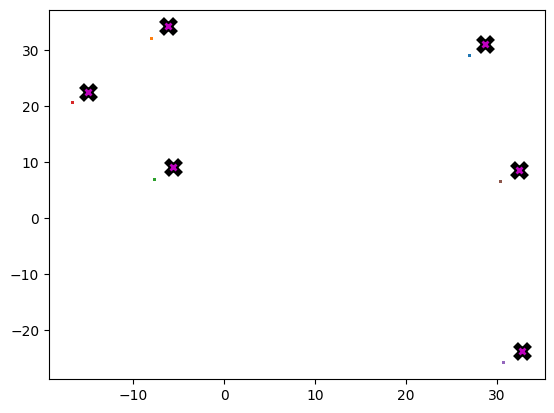

In [65]:
plot_data(centroids+2, X, n_samples)

**Homework:** implement k-means clustering, dbscan, locality sensitive hashing, or some other clustering, fast nearest neighbors, or similar algorithm of your choice, on the GPU. Check if your version is faster than a pure python or CPU version.

Bonus: Implement it in APL too!

Super bonus: Invent a new meanshift algorithm which picks only the closest points, to avoid quadratic time.

Super super bonus: Publish a paper that describes it :D

# my meanshift

## organise data into nearest points.

a matrix, where each col is the ordered indexes of points along a particular dimension

maybe add a dimension for the average loaction of a point. FILTERED POINT MORE than a std away in any dim

In [242]:
# extract a dimension
order_data = X.clone().cpu()
order_data.shape,order_data.device


(torch.Size([1500, 2]), device(type='cpu'))

In [102]:
dim = order_data[:,0].clone()[:,None]
dim.shape, dim[0], order_data[0]

(torch.Size([1500, 1]), tensor([27.555]), tensor([27.555, 27.515]))

In [ ]:
sub_dim = dim[:10] ; sub_dim

In [ ]:
sorted,_ = torch.sort(sub_dim,0) ; sorted

In [ ]:
dim,_ = torch.sort(dim,0) ; dim[:10]

In [ ]:
torch.sort(order_data[:10],0), order_data[:10]

In [ ]:
_,ranks = torch.sort(order_data[:10],0) ; ranks,_,order_data[:10]

for each point select only the points 50 points closest: in each dim, extract the 25 points above and below.
need to know the rank of current index.
the indices of rank gives me that info.

remove all points who are more than 1 std distant in any dim


In [ ]:
torch.sort(ranks, 0)

In [151]:
_,ranks = torch.sort(order_data,0)
_,orig_idx_ranks = torch.sort(ranks,0) ; orig_idx_ranks[0]

tensor([ 946, 1056])

In [ ]:
order_data[0], ranks[940:948], ranks[1054:1058]

In [255]:
dim_1, dim_2 = orig_idx_ranks[0] ; dim_1.shape, dim_1

(torch.Size([]), tensor(946))

In [216]:
#select how many indexes to take
window = 25

In [ ]:
dim_1_neigh = ranks[dim_1 - window: dim_1 + window , 0] 
dim_2_neigh = ranks[dim_2 - window: dim_2 + window , 1] ; dim_2_neigh, dim_1_neigh

In [ ]:
closest_idx = torch.concat((dim_1_neigh, dim_2_neigh)).unique() ; closest_idx

In [ ]:
 closest = order_data[closest_idx]; closest, order_data.min(), order_data.max(), order_data.std()

In [ ]:
# check avg distance

base = closest[0] ; base.shape, closest.shape, base.expand_as(closest)


In [221]:

((base - closest)**2).sum(1).sqrt().mean()

tensor(12.568)

In [222]:
def point_dist(point, tens):
    return ((point - tens)**2).sum(1).sqrt().mean()

In [254]:
#get random indexes for comp
rand_idx = torch.zeros([window * 2,1],dtype = torch.int).random_(0,1500)


In [248]:
point_dist(base, closest), point_dist(base,order_data[rand_idx])

(tensor(12.568), tensor(16.077))

In [ ]:
#tnesor of closest indexes where one dim is more than a std away. can use n_DIMS. 
bool = (((base - closest) <= order_data.std()).sum(1)) > 1
bool

In [ ]:
filtered_closest = closest[bool]; filtered_closest

In [253]:
point_dist(base, closest), point_dist(base, filtered_closest), point_dist(base,order_data[rand_idx])

(tensor(12.568), tensor(3.934), tensor(19.740))

In [278]:
#change window to account for a rank at the end or begginig
# note that each sub tensor is of  a different size
def get_closest(point, data, window):
    _,ranks = torch.sort(data,0)
    _,orig_idx_ranks = torch.sort(ranks,0) ; orig_idx_ranks[0]
    dim_1, dim_2 = orig_idx_ranks[0]
    dim_1_neigh = ranks[dim_1 - window: dim_1 + window , 0] 
    dim_2_neigh = ranks[dim_2 - window: dim_2 + window , 1] 
    closest_idx = torch.concat((dim_1_neigh, dim_2_neigh)).unique()
    closest = (order_data[closest_idx])[(((point - order_data[closest_idx]) <= order_data.std()).sum(1)) > 1]
    #add points equal to point to fill to window * 4 
    
    #bool = (((point - closest) <= order_data.std()).sum(1)) > 1
    #filtered_closest = closest[bool]
    return closest
    

In [277]:
closest_x = get_closest(order_data[20],order_data,25)
closest_x.shape

torch.Size([66, 2])

In [271]:
from fastcore.test import * 
test_close(closest,filtered_closest)


In [ ]:
#return a tensor where each row is all the distances between a point and all other points. 
def dist_b(a,b): return (((a[None]-b[:,None])**2).sum(2)).sqrt()

In [ ]:
def meanshift_fast(data, bs=500):
    n = len(data)
    X = data.clone()
    _,ranks = torch.sort(X,0)
    _,orig_idx_ranks = torch.sort(ranks,0) ; orig_idx_ranks[0]
    for it in range(5):
        for i in range(0, n, bs):
            s = slice(i, min(i+bs,n))
            #get distances             
            weight = gaussian(dist_b(X, X[s]), 2.5)
#             weight = tri(dist_b(X, X[s]), 8)
            div = weight.sum(1, keepdim=True)
            X[s] = weight@X/div
    return X

# Implementing and Optimizing Meanshift Clustering

This post includes a cool animation.

Salman Naqvi  
Wednesday, 21 June 2023

> This notebook follows the [fastai style
> guide](https://docs.fast.ai/dev/style.html).

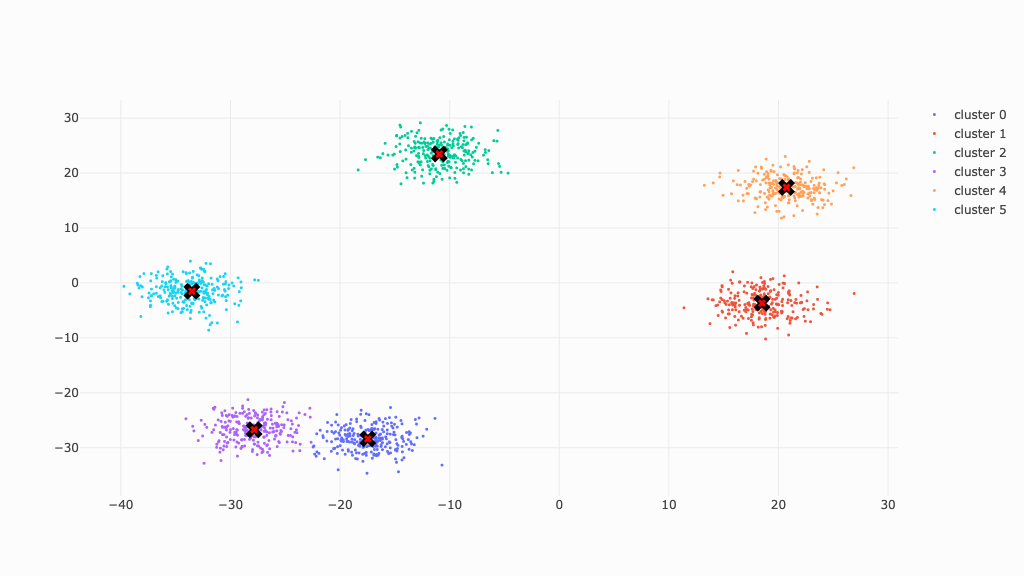

Meanshift clustering is a technique for unsupervised learning. Give this
algorithm a bunch of data and it will figure out what groups the data
can be sorted into. It does this by iteratively moving all data points
until they converge to a single point.

The steps of the algorithm can be summarized as follows:

1.  For each data point $x$ in the dataset, calculate the distance
    between $x$ and every other data point in the dataset.
2.  Calculate weights for each point in the dataset by passing the
    calculated distances through the normal distribution.
3.  Calculate the weighted average for all points in the dataset. This
    weighted average is the new location for $x$

This is the data we will work with to illustrate meanshift clustering.
The data points are put into clearly seperate clusters for the sake of
clarity.

In the end, all clusters will converge at their respective center
(marked by X).

## Implementation

Let’s start off simple and apply the algorithm to a single point.

### Calculate Distances

> For each data point $x$ in the dataset, calculate the distance between
> $x$ and every other data point in the dataset.

In [28]:
data

tensor([[27.555, 27.515],
        [25.656, 29.590],
        [24.275, 29.255],
        ...,
        [32.493, 10.760],
        [30.484,  5.739],
        [31.439,  8.249]])

In [35]:
X = data.clone(); X.shape

torch.Size([1500, 2])

In [37]:
X[0],X[0].shape,X[0, :],X[0, :].shape,X[:,0].shape

(tensor([27.555, 27.515]),
 torch.Size([2]),
 tensor([27.555, 27.515]),
 torch.Size([2]),
 torch.Size([1500]))

Each point has an $x$ coordinate and a $y$ coordinate.

In [34]:
x = X[0, :]; x - X

(tensor([[ 0.000,  0.000],
         [ 1.899, -2.075],
         [ 3.280, -1.740],
         ...,
         [-4.939, 16.755],
         [-2.930, 21.776],
         [-3.885, 19.266]]),
 tensor([27.555, 27.515]),
 torch.Size([2]),
 tensor([27.555, 27.515]),
 torch.Size([2]))

The distance metric we’ll use is [Euclidean
distance](https://www.mathsisfun.com/algebra/distance-2-points.html)
— also better known as Pythagoras’ theorem.

$$
\sqrt{(x_2 - x_1)^2 + (y_2 - y_1)^2}
$$

In [38]:
dists = (x - X).square().sum(dim=1).sqrt(); dists

tensor([ 0.000,  2.813,  3.713,  ..., 17.468, 21.972, 19.654])

### Calculate Weights

> Calculate weights for each point in the dataset by passing the
> calculated distances through the normal distribution.

The [normal
distribution](https://www.mathsisfun.com/data/standard-normal-distribution.html)
is also known as the Gaussian distribution. A distribution is simply a
way to describe how data is spread out — this isn’t applicable in our
case. What is applicable is the shape of this distribution which we will
use to calculate the weights.

$$
f(x) = \frac{1}{\sigma \sqrt{2\pi} } e^{-\frac{1}{2}\left(\frac{x-\mu}{\sigma}\right)^2}
$$

In [46]:
def gauss_kernel(x, mean, std):
  return torch.exp(-(x - mean) ** 2 / (2 * std ** 2)) / (std * torch.sqrt(2 * tensor(torch.pi)))

This is how it looks like.

From the shape of this graph, we can see that larger values of $x$ give
smaller values of $y$, which is what we want — longer distances should
have smaller weights meaning they have a smaller effect on the new
position of the point.

We can control the rate at which the weights go to zero by varying
what’s known as the bandwidth, or the standard deviation. The graph
above is generated with a bandwith of 2.5.

The graph below is generated with a bandwidth of 1.

Let’s get our weights now.

In [41]:
gauss_kernel(dists, mean=0, std=2.5)

tensor([    0.160,     0.085,     0.053,  ...,     0.000,     0.000,     0.000])

In [42]:
bw = 2.5
ws = gauss_kernel(x=dists, mean=0, std=bw)

### Move the Point

> Calculate the weighted average for all points in the dataset. This
> weighted average is the new location for $x$

In [45]:
ws.shape, X.shape, ws[:5], dists[:5]

(torch.Size([1500]),
 torch.Size([1500, 2]),
 tensor([0.160, 0.085, 0.053, 0.008, 0.129]),
 tensor([0.000, 2.813, 3.713, 6.068, 1.624]))

In [47]:
ws[:, None].shape, X.shape

(torch.Size([1500, 1]), torch.Size([1500, 2]))

Below is the formula for [weighted
average](https://www.mathsisfun.com/data/weighted-mean.html).

$$
\frac{\sum wx}{\sum w}
$$

In words, multiply each data point in the set with its corresponding
weight and sum all products. Divide that with the sum of all weights.

In [50]:
ws[:, None] * X, ws[0] * X[0, :]

(tensor([[    4.397,     4.391],
         [    2.174,     2.507],
         [    1.286,     1.550],
         ...,
         [    0.000,     0.000],
         [    0.000,     0.000],
         [    0.000,     0.000]]),
 tensor([4.397, 4.391]))

Let’s calculate the weighted average and assign it as the new location
for our point $x$.

In [51]:
x = (ws[:, None] * X).sum(dim=0) / ws.sum(); x

tensor([27.264, 28.557])

And there you have it! We just moved a single data point.

Let’s do this for all data points and for a single iteration.

In [52]:
for i, x in enumerate(X):
    dist = (x - X).square().sum(dim=1).sqrt()
    ws = gauss_kernel(x=dist, mean=0, std=bw)
    X[i] = (ws[:, None] * X).sum(dim=0) / ws.sum()

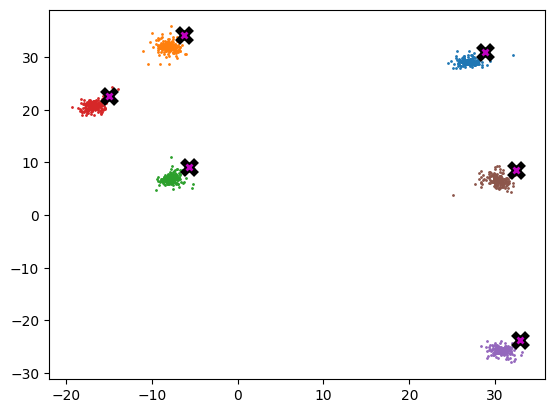

In [53]:
plot_data(centroids+2, X, n_samples)

Let’s encapsulate the algorithm so we can run it for multiple
iterations.

In [54]:
def update(X):
    for i, x in enumerate(X):
      dist = (x - X).square().sum(dim=1).sqrt()
      ws = gauss_kernel(x=dist, mean=0, std=bw)
      X[i] = (ws[:, None] * X).sum(dim=0) / ws.sum()

def meanshift(data):
   X = data.clone()
   for _ in range(5): update(X)
   return X

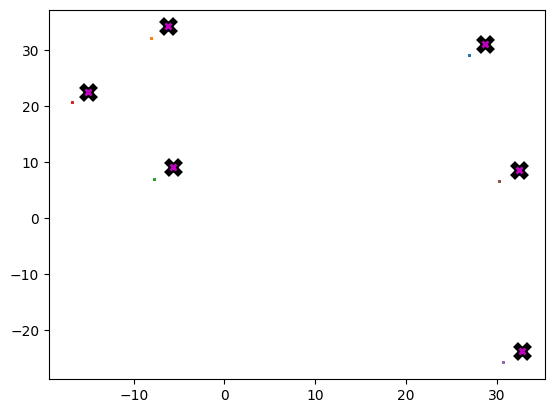

In [55]:
plot_data(centroids+2, meanshift(data), n_samples)

All points have converged.

In [56]:
%timeit -n 10 meanshift(data)

596 ms ± 2.28 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


The algorithm took roughly 1.5 seconds to run 5 iterations. We’ll
optimize the algorithm further in [Optimized
Implementation](#optimized-implementation).

As we can see below, simply moving the algorithm to the GPU won’t help
— in fact, it becamse a bit slower.

In [57]:
def update(X):
    for i, x in enumerate(X):
      dist = (x - X).square().sum(dim=1).sqrt()
      ws = gauss_kernel(x=dist, mean=0, std=bw)
      X[i] = (ws[:, None] * X).sum(dim=0) / ws.sum()

def meanshift(data):
   X = data.clone().to('cuda')
   for _ in range(5): update(X)
   return X.detach().cpu()

%timeit -n 10 meanshift(data)

738 ms ± 22 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Animation

Let’s see meanshift clustering happen in real time.

In [ ]:
X = data.clone()
fig = plot_data(centroids+2, X, n_samples, display=False)
fig.update_layout(xaxis_range=[-40, 40], yaxis_range=[-40, 40],  updatemenus=[dict(type='buttons', buttons=[
    dict(label='Play', method='animate', args=[None]),
    dict(label='Pause', method='animate', args=[[None], dict(frame_duration=0, frame_redraw='False', mode='immediate', transition_duration=0)])
])])

frames = [go.Frame(data=fig.data)]
for _ in range(5):
    update(X)
    frames.append(go.Frame(data=plot_data(centroids+2, X, n_samples, display=False).data))
fig.frames = frames
fig.show()

## Optimized Implementation

The implementation above is roughly 1.5s which is slow. Let’s perform
the algorithm on multiple data points simulataneously. We’ll then move
the operations onto the GPU.

### Calculate Distances

> For each data point $x$ in the dataset, calculate the distance between
> $x$ and every other data point in the dataset.

In [58]:
X = data.clone(); X.shape

torch.Size([1500, 2])

We’ll begin with a batch size of 8.

In [59]:
bs = 8
x = X[:bs, :]; x

tensor([[27.555, 27.515],
        [25.656, 29.590],
        [24.275, 29.255],
        [21.578, 28.565],
        [26.066, 28.165],
        [28.555, 27.660],
        [25.435, 28.909],
        [24.906, 29.790]])

In [60]:
x.shape, X.shape

(torch.Size([8, 2]), torch.Size([1500, 2]))

In [61]:
x[:, None, :].shape, X[None, ...].shape

(torch.Size([8, 1, 2]), torch.Size([1, 1500, 2]))

In [62]:
x[:, None, :] - X[None, ...]

tensor([[[ 0.000,  0.000],
         [ 1.899, -2.075],
         [ 3.280, -1.740],
         ...,
         [-4.939, 16.755],
         [-2.930, 21.776],
         [-3.885, 19.266]],

        [[-1.899,  2.075],
         [ 0.000,  0.000],
         [ 1.381,  0.335],
         ...,
         [-6.838, 18.831],
         [-4.829, 23.851],
         [-5.784, 21.341]],

        [[-3.280,  1.740],
         [-1.381, -0.335],
         [ 0.000,  0.000],
         ...,
         [-8.218, 18.495],
         [-6.210, 23.516],
         [-7.165, 21.006]],

        ...,

        [[ 1.001,  0.145],
         [ 2.900, -1.930],
         [ 4.281, -1.595],
         ...,
         [-3.938, 16.901],
         [-1.929, 21.921],
         [-2.884, 19.411]],

        [[-2.119,  1.394],
         [-0.221, -0.681],
         [ 1.160, -0.346],
         ...,
         [-7.058, 18.150],
         [-5.049, 23.170],
         [-6.004, 20.660]],

        [[-2.648,  2.275],
         [-0.750,  0.200],
         [ 0.631,  0.535],
         ...,
 

In [63]:
(x[:, None, :] - X[None, ...]).shape

torch.Size([8, 1500, 2])

In [64]:
dists = (x[:, None, :] - X[None, ...]).square().sum(dim=-1).sqrt(); dists, dists.shape

(tensor([[ 0.000,  2.813,  3.713,  ..., 17.468, 21.972, 19.654],
         [ 2.813,  0.000,  1.421,  ..., 20.034, 24.335, 22.111],
         [ 3.713,  1.421,  0.000,  ..., 20.239, 24.322, 22.194],
         ...,
         [ 1.011,  3.483,  4.568,  ..., 17.353, 22.006, 19.625],
         [ 2.537,  0.716,  1.211,  ..., 19.474, 23.714, 21.515],
         [ 3.492,  0.776,  0.828,  ..., 20.487, 24.690, 22.510]]),
 torch.Size([8, 1500]))

### Calculate Weights

> Calculate weights for each point in the dataset by passing the
> calculated distances through the normal distribution.

We can simplify the guassian kernel to a triangular kernel and still
achieve the same results, with less computation.

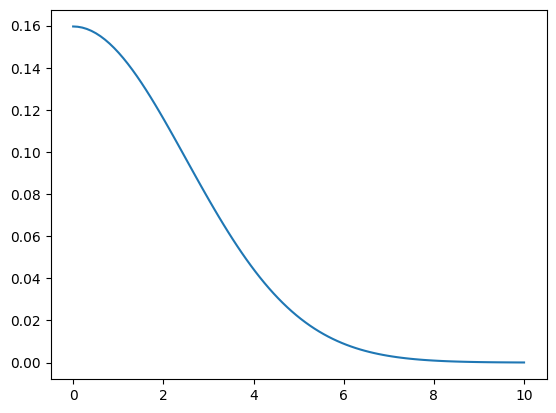

In [65]:
plot_func(partial(gauss_kernel, mean=0, std=2.5))

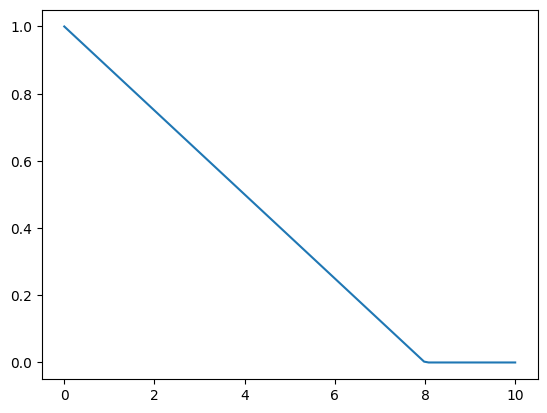

In [66]:
def tri_kernel(x, bw): return (-x+bw).clamp_min(0)/bw
plot_func(partial(tri_kernel, bw=8))

In [67]:
%timeit gauss_kernel(dists, mean=0, std=2.5)

65.7 µs ± 565 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [68]:
%timeit tri_kernel(dists, bw=8)

12.4 µs ± 19.7 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [69]:
gauss_kernel(dists, mean=0, std=2.5), tri_kernel(dists, bw=8)

(tensor([[    0.160,     0.085,     0.053,  ...,     0.000,     0.000,     0.000],
         [    0.085,     0.160,     0.136,  ...,     0.000,     0.000,     0.000],
         [    0.053,     0.136,     0.160,  ...,     0.000,     0.000,     0.000],
         ...,
         [    0.147,     0.060,     0.030,  ...,     0.000,     0.000,     0.000],
         [    0.095,     0.153,     0.142,  ...,     0.000,     0.000,     0.000],
         [    0.060,     0.152,     0.151,  ...,     0.000,     0.000,     0.000]]),
 tensor([[1.000, 0.648, 0.536,  ..., 0.000, 0.000, 0.000],
         [0.648, 1.000, 0.822,  ..., 0.000, 0.000, 0.000],
         [0.536, 0.822, 1.000,  ..., 0.000, 0.000, 0.000],
         ...,
         [0.874, 0.565, 0.429,  ..., 0.000, 0.000, 0.000],
         [0.683, 0.911, 0.849,  ..., 0.000, 0.000, 0.000],
         [0.564, 0.903, 0.897,  ..., 0.000, 0.000, 0.000]]))

In [70]:
ws = tri_kernel(dists, bw=8); ws.shape

torch.Size([8, 1500])

### Move the Points

> Calculate the weighted average for all points in the dataset. This
> weighted average is the new location for $x$

In [71]:
ws.shape, X.shape

(torch.Size([8, 1500]), torch.Size([1500, 2]))

In [72]:
ws[..., None].shape, X[None, ...].shape

(torch.Size([8, 1500, 1]), torch.Size([1, 1500, 2]))

In [73]:
(ws[..., None] * X[None, ...]).shape

torch.Size([8, 1500, 2])

In [74]:
(ws[..., None] * X[None, ...]).sum(1).shape

torch.Size([8, 2])

In [75]:
%timeit (ws[..., None] * X[None, ...]).sum(1)

50.6 µs ± 95.5 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


Let’s have another look at formula for weighted average.

$$
\frac{\sum wx}{\sum w}
$$

The numerator is actually the
[definition](https://en.wikipedia.org/wiki/Matrix_multiplication#Definition)
for matrix multiplication! Therefore we can speed up the operation above
by using the `@` operator!

In [76]:
%timeit ws @ X

3.98 µs ± 8.81 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


A roughly 40% speed up!

In [77]:
x = (ws @ X) / ws.sum(dim=1, keepdim=True); x

tensor([[27.116, 28.799],
        [26.593, 29.235],
        [26.214, 29.162],
        [25.275, 28.947],
        [26.708, 28.933],
        [27.393, 28.825],
        [26.534, 29.090],
        [26.388, 29.278]])

And there you have it! We performed this algorithm on 8 data points
simultaneously!

Let’s encapsulate the code so we can perform it over all data points and
time it.

In [78]:
?slice

Init signature: slice(self, /, *args, **kwargs)
Docstring:     
slice(stop)
slice(start, stop[, step])

Create a slice object.  This is used for extended slicing (e.g. a[0:10:2]).
Type:           type
Subclasses:     

In [79]:
bs

8

In [80]:
min(1508, 1500)

1500

In [82]:
X = data.clone()
n = len(data)
bs = 8
for i in range(0, n, bs):
    s = slice(i, min(i+bs, n))
    dists = (X[s][:, None, :] - X[None, ...]).square().sum(dim=-1).sqrt()
    ws = gauss_kernel(dists, mean=0, std=2.5)
    X[s] = (ws @ X) / ws.sum(dim=1, keepdim=True)

In [ ]:
plot_data(centroids+2, X, n_samples)

In [ ]:
def update(X):
  for i in range(0, n, bs):
    s = slice(i, min(i+bs, n))
    dists = (X[s][:, None, :] - X[None, ...]).square().sum(dim=-1).sqrt()
    ws = egauss_kernel(dists, mean=0, std=2.5)
    X[s] = (ws @ X) / ws.sum(dim=1, keepdim=True)

def meanshift(data):
   X = data.clone()
   for _ in range(5): update(X)
   return X

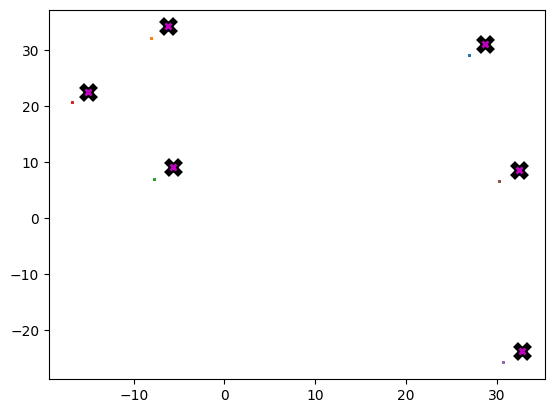

In [83]:
plot_data(centroids+2, meanshift(data), n_samples)

In [85]:
%timeit -n 10 meanshift(data)

791 ms ± 17.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


From 1.5 seconds to 0.5 seconds! A 3x speed increase — very nice!

Let’s move onto the GPU and now see what improvements we get.

In [86]:
def meanshift(data):
   X = data.clone().to('cuda')
   for _ in range(5): update(X)
   return X.detach().cpu()

%timeit -n 10 meanshift(data)

822 ms ± 10.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


0.5s to 0.25s — a 2x speed increase!

## Conclusion

Meanshift clustering simply involves moving points, by taking into
account surrounding points, iteratively until they converge.

If you have any comments, questions, suggestions, feedback, criticisms,
or corrections, please do post them down in the comment section below!